In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
torch.__version__

'2.3.0+cpu'

In [3]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [48]:
x_train_tmp_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\DATASET\temp_new"
x_train_dsp_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\DATASET\disp_new"
y_train_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\DATASET\CIRCULAR_VANE_Shape_Images_1559"


x_tmp_elements = os.listdir(x_train_tmp_folder_path)
x_dsp_elements = os.listdir(x_train_dsp_folder_path)
y_elements = os.listdir(y_train_folder_path)


In [49]:
x_tmp_elements.sort()
x_dsp_elements.sort()
y_elements.sort()
x_dsp_elements[1115:1120],x_tmp_elements[1115:1120],y_elements[1115:1120]

(['new (6).png',
  'new (60).png',
  'new (600).png',
  'new (601).png',
  'new (602).png'],
 ['new_temp (6).png',
  'new_temp (60).png',
  'new_temp (600).png',
  'new_temp (601).png',
  'new_temp (602).png'],
 ['vaneimg (6).jpeg',
  'vaneimg (60).jpeg',
  'vaneimg (600).jpeg',
  'vaneimg (601).jpeg',
  'vaneimg (602).jpeg'])

In [50]:
# DEVELOPING X_train MATRIX

def get_images(tmp_elements,disp_elements,y_elements,size):
  X= np.zeros((size,2,256,256))
  Y= np.zeros((size,1,256,256))
  for index, (tmp_element, dsp_element) in enumerate(zip(tmp_elements, disp_elements)):
      # Load images for each channel
      tmp_element_path = os.path.join(x_train_tmp_folder_path, tmp_element)
      dsp_element_path = os.path.join(x_train_dsp_folder_path, dsp_element)
      img_tmp = imread(tmp_element_path)
      img_dsp = imread(dsp_element_path)

      # Reshape images for each channel
      img_tmp = img_tmp.reshape((1,256,256))
      img_dsp = img_dsp.reshape((1,256,256))

      # Combine channels
      img_combined = (np.concatenate((img_tmp, img_dsp), axis=0)-0.5)/0.5

      # Assign to X_train
      X[index] = img_combined

  # DEVELOPING Y_train MATRIX
  for index,Y_train_element in enumerate(y_elements):
      
      element_path = os.path.join(y_train_folder_path, Y_train_element)
      img = imread(element_path)
      img = np.mean(img, axis=2)
      img = img/127.5-1
      img = img.reshape((1,256, 256))
      Y[index] = img
  return X,Y

In [51]:
x,y = get_images(x_tmp_elements,x_dsp_elements,y_elements,len(x_tmp_elements))

In [52]:
x.shape,y.shape

((1559, 2, 256, 256), (1559, 1, 256, 256))

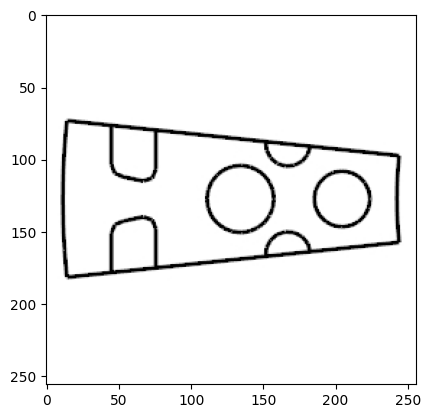

In [53]:
img=imread(os.path.join(y_train_folder_path,y_elements[15]))
plt.imshow(img)

In [54]:
x.max(),x.min(),y.max(),y.min()

(1.0, -1.0, 1.0, -1.0)

In [55]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.leaky_relu = nn.LeakyReLU(0.2)
        nn.init.normal_(self.conv.weight, mean=0.0, std=0.02)
        if self.conv.bias is not None:
            nn.init.constant_(self.conv.bias, 0.0)

    def forward(self, x):
        x = self.conv(x.float())
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=True):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if dropout else None
        self.leaky_relu = nn.LeakyReLU(0.1)
        nn.init.normal_(self.conv_transpose.weight, mean=0.0, std=0.02)
        if self.conv_transpose.bias is not None:
            nn.init.constant_(self.conv_transpose.bias, 0.0)

    def forward(self, x, skip_con):
        x = self.conv_transpose(x.float())
        x = self.batch_norm(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = torch.cat((x, skip_con.float()), dim=1)
        x = self.leaky_relu(x)
        return x

class UNet(nn.Module):
    def __init__(self, input_shape=(2, 256, 256)):
        super(UNet, self).__init__()
        self.e1 = EncoderBlock(input_shape[0], 64, batch_norm=False)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        self.e5 = EncoderBlock(512, 512)
        self.e6 = EncoderBlock(512, 512)
        self.e7 = EncoderBlock(512, 512)
    

        self.b = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        nn.init.normal_(self.b.weight, mean=0.0, std=0.02)
        if self.b.bias is not None:
            nn.init.constant_(self.b.bias, 0.0)
        self.b_relu = nn.ReLU()

        self.d1 = DecoderBlock(512, 512)
        self.d2 = DecoderBlock(1024, 512)
        self.d3 = DecoderBlock(1024, 512)
        self.d4 = DecoderBlock(1024, 512, dropout=False)
        self.d5 = DecoderBlock(1024, 256, dropout=False)
        self.d6 = DecoderBlock(512, 128, dropout=False)
        self.d7 = DecoderBlock(256, 64, dropout=False)

        self.output_layer = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=0.02)
        if self.output_layer.bias is not None:
            nn.init.constant_(self.output_layer.bias, 0.0)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.float()
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)

        b = self.b(e7)
        b = self.b_relu(b)

        d1 = self.d1(b, e7)
        d2 = self.d2(d1, e6)
        d3 = self.d3(d2, e5)
        d4 = self.d4(d3, e4)
        d5 = self.d5(d4, e3)
        d6 = self.d6(d5, e2)
        d7 = self.d7(d6, e1)

        output = self.output_layer(d7)
        output = self.tanh(output)
        return output

In [56]:
from torchsummary import summary

# Define the model
generator = UNet()

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


generator.to(device)

# Print the model summary
summary(generator, input_size=(2, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,112
         LeakyReLU-2         [-1, 64, 128, 128]               0
      EncoderBlock-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
      EncoderBlock-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
     EncoderBlock-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

In [57]:

x_np = x[0:100]
y_np = y[0:100]
BS=10
# Convert NumPy arrays to PyTorch tensors
x_tensor = torch.tensor(x_np)
y_tensor = torch.tensor(y_np)

# Create a PyTorch dataset
dataset = TensorDataset(x_tensor, y_tensor) 


train_loader = DataLoader(
        dataset,
        batch_size=BS)
       

In [58]:
#model_name = 'Weights_gradual_increase/app10_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app11_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app12_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app13_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app14_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app15_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app16_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app17'_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app18_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app19_p2p_gen_d_500_bs_16.pth'
#model_name = 'Weights_gradual_increase/app110_p2p_gen_d_500_bs_16.pth'
#model_name = 'short_p2p_unet_gpu0_12.pth'
model_name = 'p2p_unet_gpu0_12.pth'

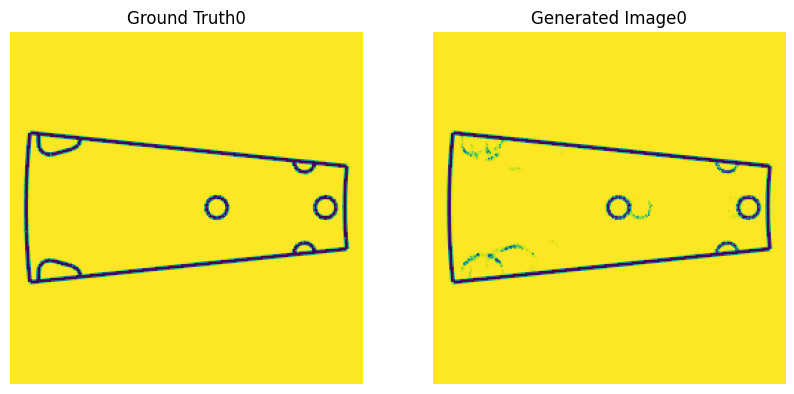

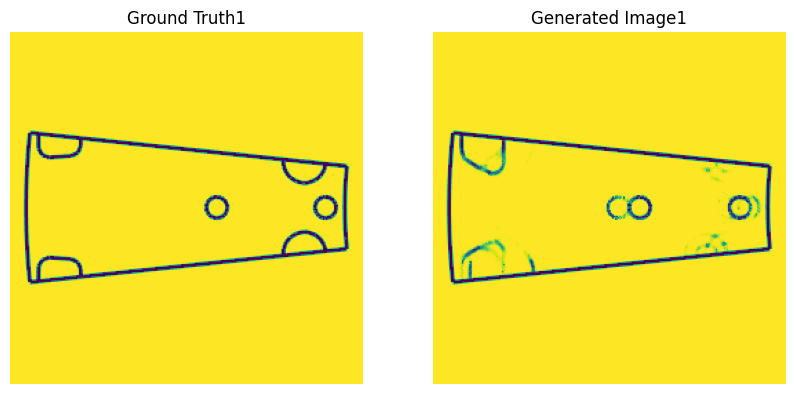

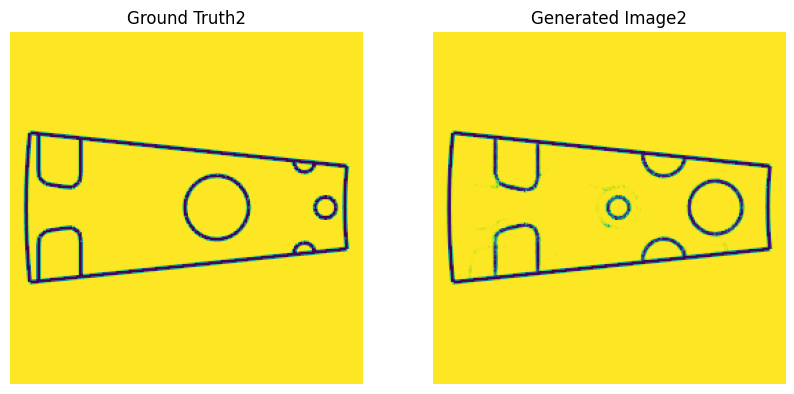

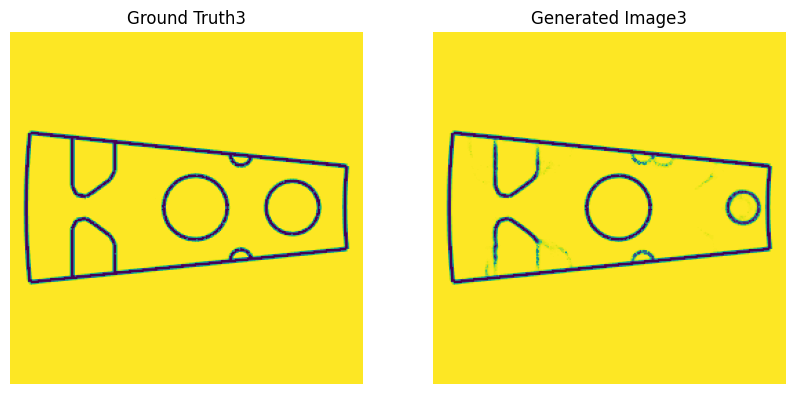

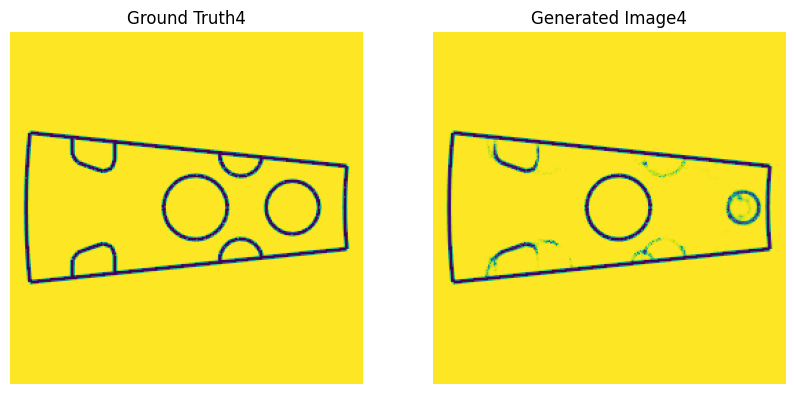

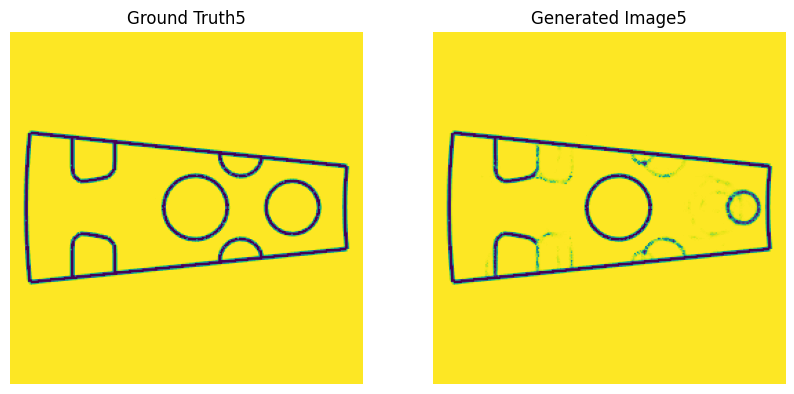

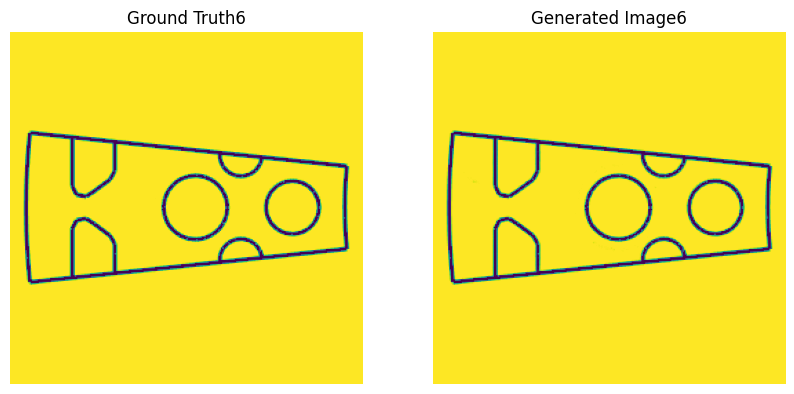

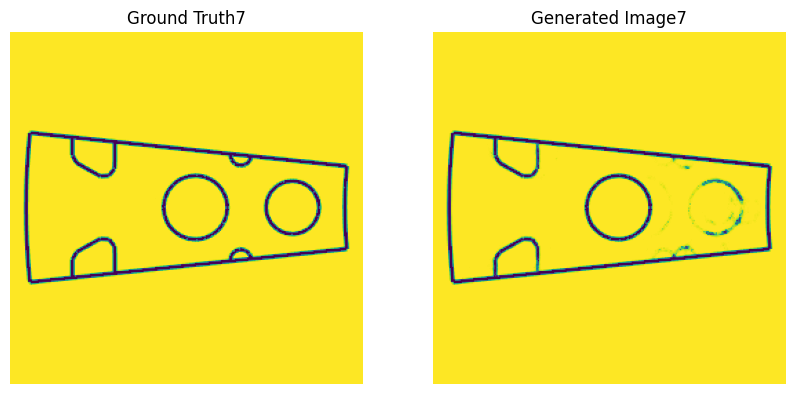

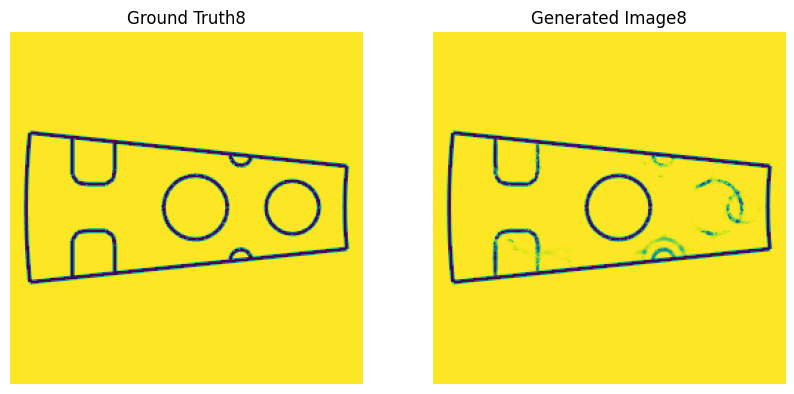

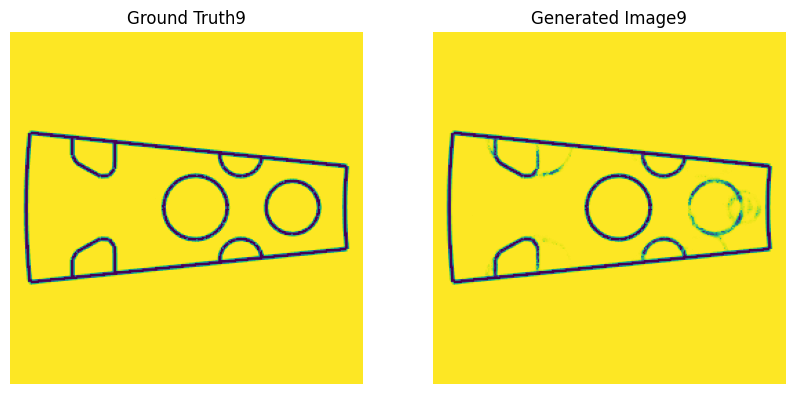

In [59]:
#MODEL TESTING

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transform to normalize the data
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])
'''



# Load the model
model = UNet()
model.load_state_dict(torch.load(model_name,map_location=device))
                   
#model = torch.load(model_name,map_location=torch.device('cpu'))
model.eval()  # Set the model to evaluation mode

# Get a batch of test images and labels
test_images, test_labels = next(iter(train_loader))

# Make predictions
with torch.no_grad():  # No need to compute gradients for evaluation
    predicted = model(test_images)

predicted = predicted.permute(0, 2, 3, 1)
test_labels = test_labels.permute(0, 2, 3, 1)
#plt.imshow(test_labels[0])


# Helper function to unnormalize and convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



for i in range(BS):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the first image
    axs[0].imshow(test_labels[i])
    axs[0].set_title('Ground Truth'+str(i))
    axs[0].axis('off')  # Hide the axes

    # Plot the second image
    axs[1].imshow(predicted[i])
    axs[1].set_title('Generated Image'+str(i))
    axs[1].axis('off')  # Hide the axes

    # Display the plot
    plt.show()

plt.show()




In [60]:

x_np_test = x[1300:1400]
y_np_test = y[1300:1400]
BS=10
# Convert NumPy arrays to PyTorch tensors
x_tensor_test = torch.tensor(x_np_test)
y_tensor_test = torch.tensor(y_np_test)

# Create a PyTorch dataset
dataset_test = TensorDataset(x_tensor_test, y_tensor_test) 


test_loader = DataLoader(
        dataset_test,
        batch_size=BS)
       

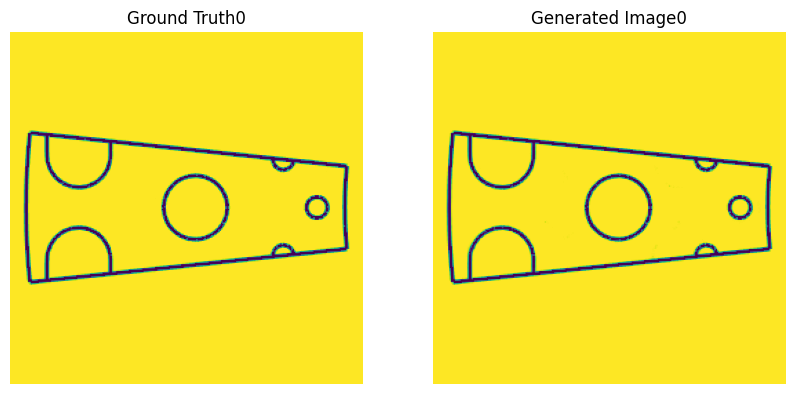

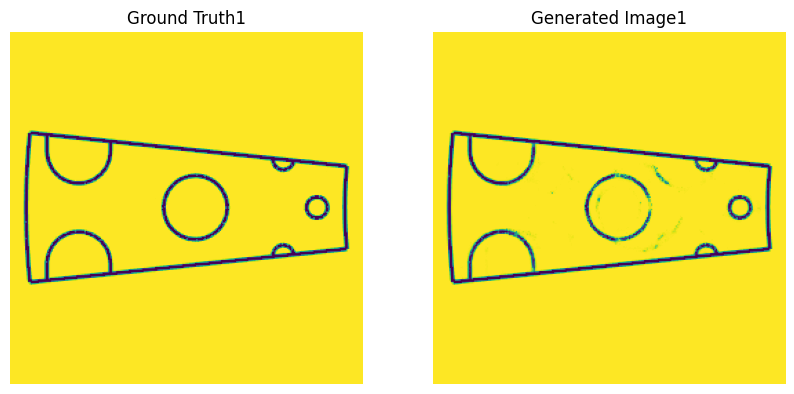

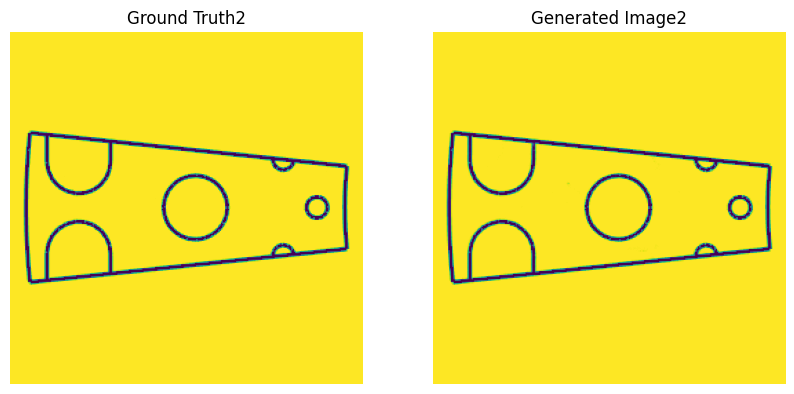

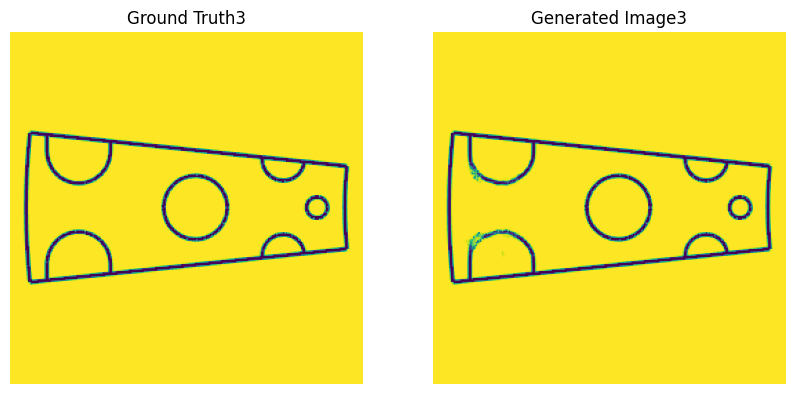

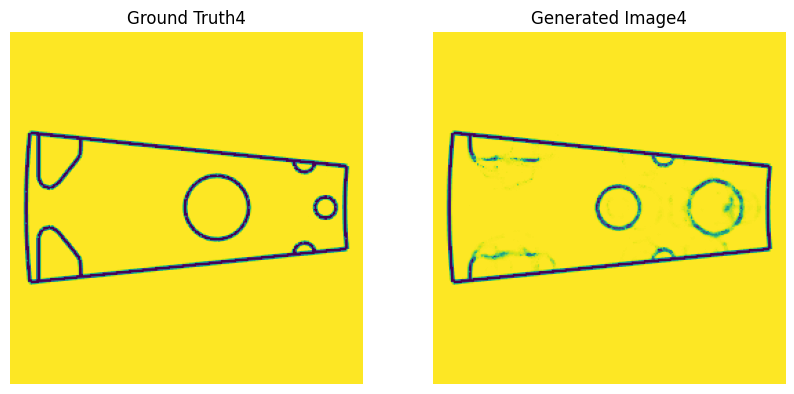

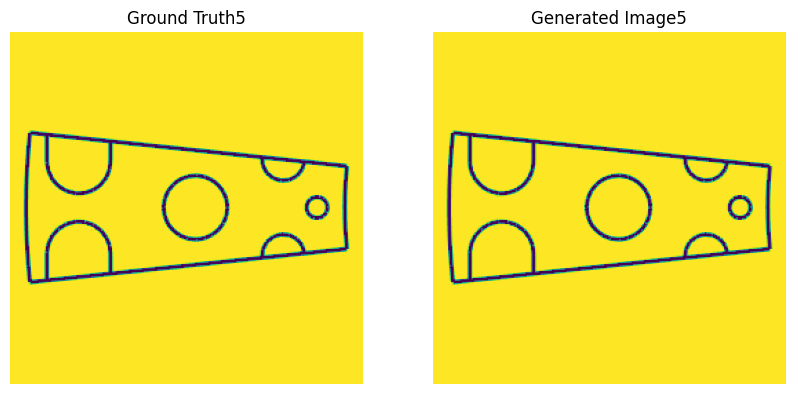

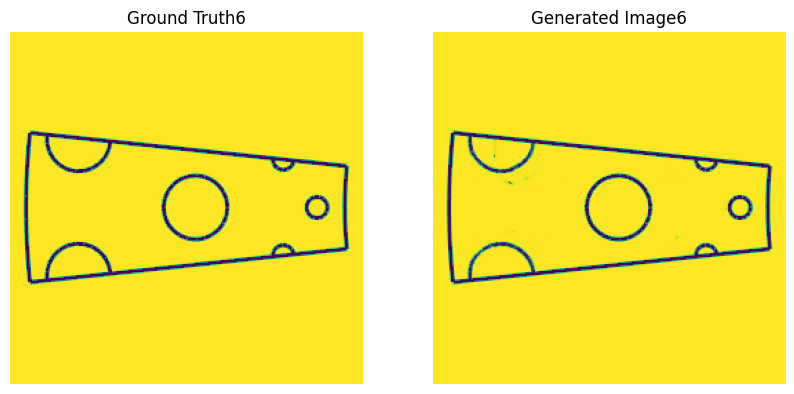

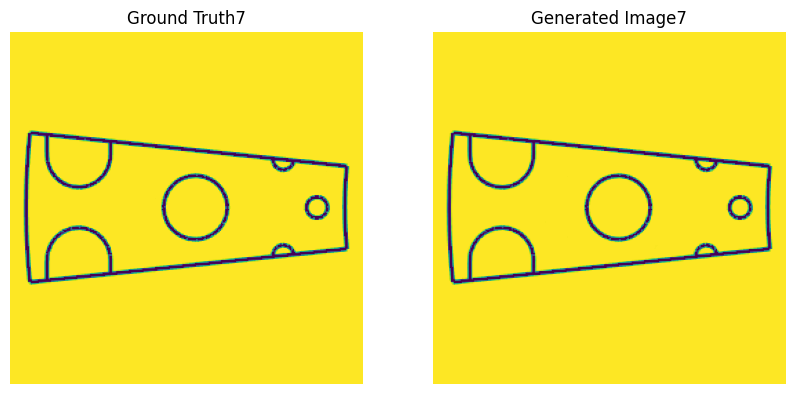

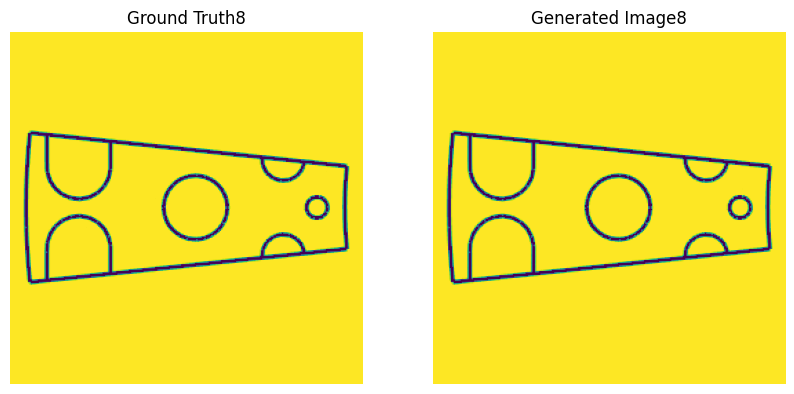

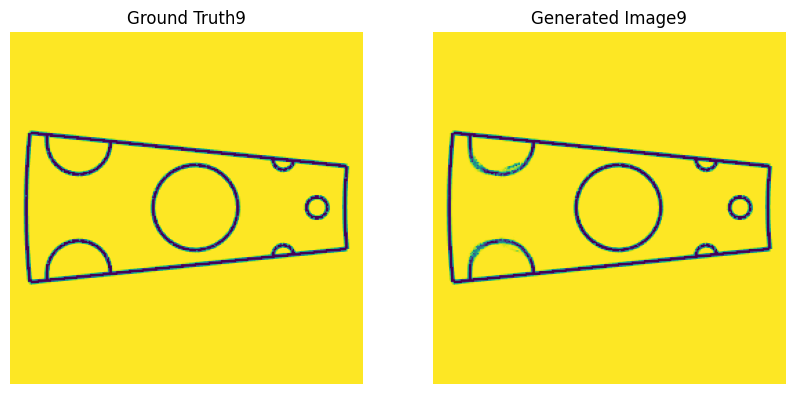

In [62]:
#MODEL TESTING

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transform to normalize the data
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])
'''



# Load the model
#model = GeneratorModel(input_shape=(2,256,256))
model = UNet()
model.load_state_dict(torch.load(model_name,map_location=device))


#model = torch.load(model_name,map_location=device)
model.eval()  # Set the model to evaluation mode

# Get a batch of test images and labels
test_images, test_labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():  # No need to compute gradients for evaluation
    predicted = model(test_images)

predicted = predicted.permute(0, 2, 3, 1)
test_labels = test_labels.permute(0, 2, 3, 1)
#plt.imshow(test_labels[0])


# Helper function to unnormalize and convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



for i in range(BS):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the first image
    axs[0].imshow(test_labels[i])
    axs[0].set_title('Ground Truth'+str(i))
    axs[0].axis('off')  # Hide the axes

    # Plot the second image
    axs[1].imshow(predicted[i])
    axs[1].set_title('Generated Image'+str(i))
    axs[1].axis('off')  # Hide the axes

    # Display the plot
    plt.show()

plt.show()




In [ ]:
res=generator(tf.expand_dims(x[1499],axis=0))
plt.imshow(res[0],cmap='gray')